# Prepare Dataset
> Note: Colab only

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Capstone/Eye-Infection-Dataset/ .
!mv ./Eye-Infection-Dataset ./dataset
!rm ./dataset/LICENSE.md

# Setup

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO
from ipywidgets import widgets
from google.colab import files

In [ ]:
DATASET_PATH = './dataset'
CLASSES = sorted(os.listdir(DATASET_PATH))
IMAGE_SIZE=(150, 150)

# Data Processing

In [68]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    batch_size=32,
    seed=8
)

Found 615 files belonging to 3 classes.
Using 492 files for training.
Using 123 files for validation.


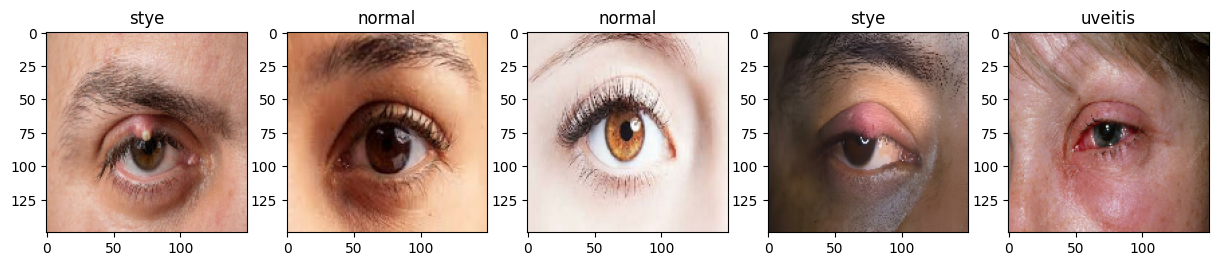

In [69]:
imgs = list(train_ds.take(5))[0]

# print(imgs)

plot, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes):
  img = tf.keras.utils.array_to_img(imgs[0][i])
  lbl = CLASSES[np.argmax(imgs[1][i].numpy())]

  ax.title.set_text(lbl)
  ax.imshow(img)

In [70]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image

In [71]:
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_image(x), y))

In [72]:
train_ds_pref = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_pref = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Setup

In [226]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CustomCallback, self).__init__()
    self.prev_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    self.prev_acc = logs['accuracy']

    # Early stop when there is no accuracy or loss improvement
    if epoch > 30 and self.prev_acc < 0.5:
      self.model.stop_training = True
      print("\nStopped the training because there is no improvement")

    # Early stop when the model has achieved the desired accuracy
    if (logs['loss'] < 0.1 and logs['val_loss'] < 0.1) and (logs['accuracy'] >= 0.98 and logs['val_accuracy'] >= 0.98):
      self.model.stop_training = True
      print("\nAlready met the desired accuracy")

In [227]:
tf.keras.backend.clear_session()

In [228]:
model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
])

In [229]:
model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 2,619,203 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [230]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5.0119e-04),
    loss=tf.keras.losses.Huber(),
    metrics=['accuracy']
)

model_obj = model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3974 - loss: 72.7035 - val_accuracy: 0.4228 - val_loss: 48.0645
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4580 - loss: 42.0429 - val_accuracy: 0.4878 - val_loss: 26.4879
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5117 - loss: 22.9027 - val_accuracy: 0.5203 - val_loss: 13.8617
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5531 - loss: 11.8616 - val_accuracy: 0.5285 - val_loss: 6.9333
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5059 - loss: 5.8828 - val_accuracy: 0.5366 - val_loss: 3.3181
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5635 - loss: 2.7884 - val_accuracy: 0.5528 - val_loss: 1.5238
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5660 - loss: 1.2768 - val_accuracy: 0.6667 - val_loss: 0.6959
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5598 - loss: 0.5858 - val_accu

# Model Tuning (Experiment)
> This section is only for experiment. Therefore, optional. Make sure you haven't compile or train the model yet!

In [201]:
# Learning rate scheduler

tf.keras.backend.clear_session()

model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
])

model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch / 20))

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
)

model_obj = model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[lr_schedule]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.1111 - mae: 0.4444 - val_loss: 0.1109 - val_mae: 0.4439 - learning_rate: 1.0000e-06
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1110 - mae: 0.4441 - val_loss: 0.1107 - val_mae: 0.4436 - learning_rate: 1.1220e-06
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1108 - mae: 0.4438 - val_loss: 0.1106 - val_mae: 0.4433 - learning_rate: 1.2589e-06
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1107 - mae: 0.4435 - val_loss: 0.1104 - val_mae: 0.4429 - learning_rate: 1.4125e-06
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1105 - mae: 0.4432 - val_loss: 0.1102 - val_mae: 0.4424 - learning_rate: 1.5849e-06
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1104 - mae: 0.4430 - val_loss: 0.1100 - val_mae: 0.4420 - learning_rate: 1.7783e-06
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1103 - mae: 0.4427 - val_loss: 0.1098 - val_mae: 0.4415 - lea

# Model Evaluation

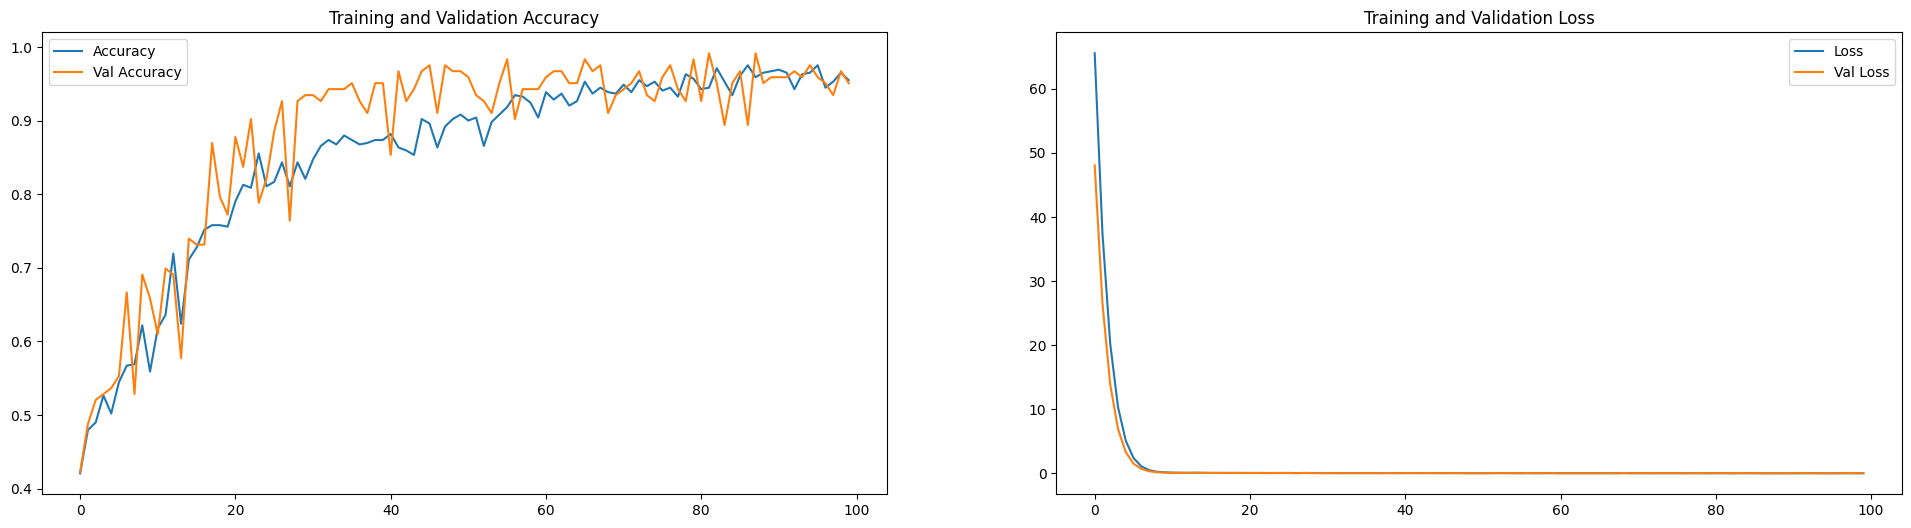

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

ax[0].plot(model_obj.history['accuracy'], label='Accuracy')
ax[0].plot(model_obj.history['val_accuracy'], label='Val Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(model_obj.history['loss'], label='Loss')
ax[1].plot(model_obj.history['val_loss'], label='Val Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

# Testing

Saving th-2173159978 to th-2173159978 (2)
Probability: [1.8531950e-04 9.9944550e-01 3.6925863e-04]
Prediction: stye



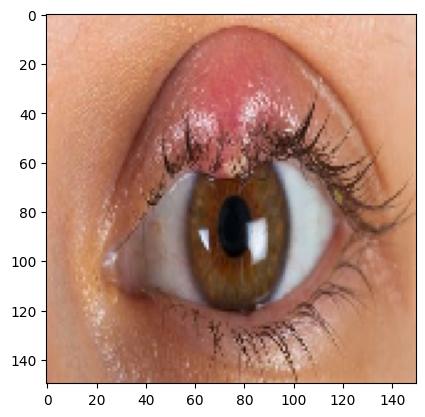

In [234]:
uploaded = files.upload()

for f in uploaded.keys():
  img = tf.keras.preprocessing.image.load_img(f, target_size=IMAGE_SIZE)

  plt.imshow(img)

  img = tf.keras.utils.img_to_array(img)
  img /= 255.0
  img = tf.expand_dims(img, axis=0)

  prediction = model.predict(img, verbose=0)[0]

  print(f'Probability: {prediction}')
  print(f'Prediction: {CLASSES[np.argmax(prediction)]}\n')